# Introduction

The purpose of this notebook is to analyze the data and then modelize the mortality based on the features given in the dataset.

To reach this goal, we will follow the following steps:
- produce an exploratory analysis of the data, the role of which is to assess the quality of the data and especially to identify highly correlated features
- build a model based on stacking
- optimize this model in terms of the number of basic models and the number of features.

For this experience, we will keep:
- 5 models having a train score greater than 0.8
- 5 features having a correlation coefficient smaller than 0.75.

The results are stored in a [database in Kaggle](https://www.kaggle.com/datasets/philippebillet/stacking-importance), and they are analyzed in [this notebook](https://www.kaggle.com/code/philippebillet/stacking-importances-result-analysis).

This notebook has been generated using [EZStacking](https://github.com/phbillet/EZStacking).

_N.B._: 
- as it seems that it is not possible to edit a Kaggle dataset from a Kaggle notebook, this data have been generated directly on my PC
- for more details on how it works, just follow the links given above.

# EDA & Modelling

In [1]:
random_state = 42

## Package loading

In [2]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import math
import keras
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn import set_config
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import GaussianNB
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import LayerNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from pandas.api.types import is_numeric_dtype
from itertools import product
from joblib import dump
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from yellowbrick.classifier import classification_report
from yellowbrick.classifier import class_prediction_error
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import precision_recall_curve
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.classifier.threshold import discrimination_threshold
from yellowbrick.features import pca_decomposition
from yellowbrick.features import rank1d
from yellowbrick.features import rank2d
from yellowbrick.target import balanced_binning_reference
from yellowbrick.target import class_balance
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances
from yellowbrick.contrib.missing import MissingValuesBar
from yellowbrick.contrib.missing import MissingValuesDispersion
from yellowbrick.target.feature_correlation import feature_correlation


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
from scipy import stats
from pandas.api.types import is_numeric_dtype
from sklearn.base import BaseEstimator, is_classifier, is_regressor, TransformerMixin
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, recall_score 
# Technical functions

def plot_dataframe_structure(df):
    """
    Plot dataframe structure: It shows the different data types in the dataframe.

    Parameters
    ----------
    df: Pandas dataframe
    
    Returns
    -------
    Plotting
    """
    plt.figure()
    df.dtypes.value_counts().plot.pie(ylabel='')
    plt.title('Data types')
    plt.show()

def plot_categorical(df):
    """
    Plot the number of different values for each categorical feature in the dataframe.

    Parameters
    ----------
    df: Pandas dataframe
    
    Returns
    -------
    Plotting
    """
    plt.figure()
    df.nunique().plot.bar()
    plt.title('Number of different values')
    plt.show()
    
def duplicates(df):
    """
    Remove the duplicate rows from dataframe.

    Parameters
    ----------
    df: Pandas dataframe
    
    Returns
    -------
    df: Pandas dataframe without duplicate rows 
    """    
    duplicate_rows_df = df[df.duplicated()]
    if duplicate_rows_df.shape[0] > 0:
       print('Number of rows before removing:', df.count()[0])
       print('Number of duplicate rows:', duplicate_rows_df.shape[0])
       df = df.drop_duplicates()
       print('Number of rows after removing:', df.count()[0])
    else:
       print('No duplicate rows.')
    return df

def drop_na(df, threshold_NaN):
    """
    Remove the columns from dataframe containing NaN depending on threshold_NaN.

    Parameters
    ----------
    df: Pandas dataframe
    threshold_NaN: in [0, 1], from GUI
    
    Returns
    -------
    df: Pandas dataframe 
    drop_cols: list of dropped columns
    """    
    isna_stat = (df.isna().sum()/df.shape[0]).sort_values(ascending=True)
    drop_cols = []
    if isna_stat.max() > 0.0:
       drop_cols = np.array(isna_stat[isna_stat > threshold_NaN].index)
       print('Drop columns containing more than', threshold_NaN*100,'% of NaN:', drop_cols)
       df = df.drop(drop_cols, axis=1)
    else:
       print('No need to drop columns.')
    return df, drop_cols

def encoding(df, threshold_cat, target_col):
    """
    Encode the data.

    Parameters
    ----------
    df: Pandas dataframe
    threshold_cat: integer, if the number of different values of a given column is less than this limit, 
    this column is considered as categorical. 
    
    Returns
    -------
    df: Pandas dataframe 
    encoded_cols: Pandas dataframe of columns with their encoding and range
    """      
    encoded_cols = []
    for c in df.columns:
        if df[c].dtypes == 'object' or df[c].dtypes.name == 'category': 
           encoded_cols.append([c, 'cat', df[c].dropna().unique().tolist()])
           print('Encoding object column:', c)
           df[c] = df[c].factorize()[0].astype(np.int)
        elif is_numeric_dtype(df[c]): 
             if df[c].unique().shape[0] > threshold_cat: 
                encoded_cols.append([c, 'num', [df[c].min(), df[c].max()]])
                print('Encoding numeric column:', c)
                df[c]=(df[c]-df[c].mean())/df[c].std()
             else:
                print('Column ', c,' is categorical.')
                encoded_cols.append([c, 'cat', df[c].dropna().unique().tolist()])
        else: 
             print('Unknown type ', df[c].dtypes,' for column:',c) 
             df = df.drop(c, axis=1)
             drop_cols = np.unique(np.concatenate((drop_cols, c)))
    encoded_cols = pd.DataFrame(np.array(encoded_cols), columns=['column_name', 'column_type', 'column_range'])
    encoded_cols = encoded_cols.loc[encoded_cols['column_name'] != target_col]
    encoded_cols.to_csv('schema.csv', index=False)
    return df, encoded_cols

def imputation(df):
    """
    Impute NaN in the dataframe using IterativeImputer.

    Parameters
    ----------
    df: Pandas dataframe
    
    Returns
    -------
    df: Pandas dataframe 
    """        
    isna_stat = (df.isna().sum()/df.shape[0]).sort_values(ascending=True) 
    if isna_stat.max() > 0.0: 
       print('Imputing NaN using IterativeImputer') 
       df = pd.DataFrame(IterativeImputer(random_state=0).fit_transform(df), columns = df.columns)  
    else: 
       print('No need to impute data.')
    return df

def outliers(df, threshold_Z):
    """
    Remove the outliers from dataframe according to Z_score.

    Parameters
    ----------
    df: Pandas dataframe
    threshold_Z: number from GUI. 
    
    Returns
    -------
    df: Pandas dataframe. 
    """  
    Z_score = np.abs(stats.zscore(df)) 
    df_o_Z = df[(Z_score < threshold_Z).all(axis=1)]
    if df_o_Z.shape[0] != 0:
       print('Using Z_score, ', str(df.shape[0] - df_o_Z.shape[0]) ,' rows will be suppressed.') 
       df = df_o_Z
    else:
       print('Possible problem with outliers treatment, check threshold_Z') 
    return df

def correlated_columns(df, threshold_corr, target_col):
    """
    Display correlation matrix of features, and returns the list of the too correlated features
    according to threshold_corr.

    Parameters
    ----------
    df: Pandas dataframe
    threshold_corr: number from GUI
    target: target column
    Returns
    -------
    correlated_features: list of the features having a correlation greater than threshold_corr. 
    """  
    df = df.drop(target_col, axis=1)
    corr_matrix = df.corr() 
    correlated_features=[]
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold_corr: # we are interested in absolute coeff value
               colname = corr_matrix.columns[i]  # getting the name of column
               correlated_features.append(colname)
    correlated_features = list(dict.fromkeys(correlated_features))
    return correlated_features

def plot_sns_corr_class(df, target_col):
    """
    Plot correlation information for classification problem (if Seaborn option is checked).

    Parameters
    ----------
    df: Pandas dataframe
    target_col: name of the target column. 
    
    Returns
    -------
    Plotting. 
    """     
    g = sns.PairGrid(df, hue=target_col) 
    g.map_upper(sns.scatterplot) 
    g.map_lower(sns.kdeplot) 
    g.map_diag(sns.kdeplot, lw=3, legend=False) 
    g.add_legend() 
    g.fig.suptitle('Pairwise data relationships', y=1.01) 
    plt.show()
    
def plot_sns_corr_regre(df, target_col):
    """
    Plot correlation information for regression problem (if Seaborn option is checked).

    Parameters
    ----------
    df: Pandas dataframe
    target_col: name of the target column. 
    
    Returns
    -------
    Plotting. 
    """      
    g = sns.PairGrid(df)
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, lw=3, legend=False)
    g.fig.suptitle('Pairwise data relationships', y=1.01)
    plt.show()
    
class Decorrelator(BaseEstimator, TransformerMixin):
    """
    Decorrelator is a class used to eliminate too correlated columns depending on a threshold during preprocessing.

    Parameters
    ----------
    threshold_corr
    """  
    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()  
        if not isinstance(X, pd.DataFrame):
           X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)
    
class ColumnsDropper(BaseEstimator, TransformerMixin):
    """
    ColumnsDropper is a class used to drop columns from a dataset.

    Parameters
    ----------
    cols : list of columns dropped by the transformer
    """  
    def __init__(self, cols):
        if not isinstance(cols, list):
            self.cols = [cols]
        else:
            self.cols = cols

    def fit(self, X: pd.DataFrame, y: pd.Series):
        # there is nothing to fit
        return self

    def transform(self, X:pd.DataFrame):
        X = X.copy()
        return X[self.cols]    
    
def model_filtering(level_0, model_imp, nb_model, score_stack, threshold_score):
    """
    Suppress estimators from level 0 having a test score smaller than threshold_score (from score_stack), then 
    keep nb_model best estimators (according to model_imp).
    Parameters
    ----------
    level_0: list of estimators of level 0
    model_imp: sorted array of model importance
    nb_model : number of model to keep
    score_stack: accuracy of estimators on train and test sets in a tabular
    threshold_score : minimal score
    
    Returns
    -------
    list of filtered estimators of level 0
    """
    # it is not possible to keep more models than we initially have
    if nb_model > len(level_0):
       nb_model = len(level_0)
    
    # keep model names and test scores
    score_stack = np.delete(np.delete(score_stack, 1, axis =1), -1, axis = 0)
    # keep models having test score greater than threshold_score 
    score_stack = score_stack[score_stack[:,1] > threshold_score]
    
    # it is not possible to keep more models than we have filtered    
    if nb_model > len(score_stack):
       nb_model = len(score_stack)
    
    # keep models (in importance array) having test score greater than threshold_score
    model_imp = model_imp[np.in1d(model_imp[:, 0], score_stack)]
    model_imp_f = model_imp[np.argpartition(model_imp[:,1], -nb_model)[-nb_model:]].T[0]
    
    return list(filter(lambda x: x[0] in model_imp_f, level_0))

def feature_filtering(feature_importance, nb_feature):
    """
    Separate features in two lists, the first one contains the nb_feature most important features, 
    the second one contains the complement
    Parameters
    ----------
    feature_importance: array of features with their importance
    nb_feature: number of features we want to keep
    
    Returns
    -------
    best_feature: list of nb_feature most important features
    worst_feature: list of the worst important features
    """
    # check nb_feature
    if nb_feature > feature_importance.shape[0]:
       nb_feature = feature_importance.shape[0] 
    
    best_feature = feature_importance[np.argpartition(feature_importance[:,1], -nb_feature)[-nb_feature:]].T[0]
    worst_feature = list(set(feature_importance.T[0]) - set(best_feature))

    return best_feature, worst_feature

def split(X, y, random_state, test_size=0.33, threshold_entropy=0.7, undersampling=False, undersampler=None):
    """
    Split dataframe into train and test sets.
    If the Shannon entropy of the target dataset is less than 0.7, RepeatedStratifiedKFold is used

    Parameters
    ----------
    X: feature dataframe
    y: target dataframe
    
    Returns
    -------
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    """
    s_e = shannon_entropy(y)
    if s_e < threshold_entropy:
       if undersampling: 
          if undersampler == 'Random': 
             from imblearn.under_sampling import RandomUnderSampler
             us = RandomUnderSampler()
          elif undersampler == 'Centroids': 
             from imblearn.under_sampling import ClusterCentroids
             us = ClusterCentroids()
          elif undersampler == 'AllKNN': 
             from imblearn.under_sampling import AllKNN
             us = AllKNN()
          elif undersampler == 'TomekLinks': 
             from imblearn.under_sampling import TomekLinks
             us = TomekLinks()
          else:
             print("Unknown undersampler")       
          X, y = us.fit_resample(X, y)
          print("Shannon Entropy = {:.4}, split using undersampler {} and RepeatedStratifiedKFold".format(s_e, undersampler)) 
       else: 
          print("Shannon Entropy = {:.4}, split using RepeatedStratifiedKFold".format(s_e)) 
       skfold = RepeatedStratifiedKFold(n_splits=5, random_state = random_state)
       # enumerate the splits and summarize the distributions
       for ind_train, ind_test in skfold.split(X, y):
           X_train, X_test = X.iloc[ind_train], X.iloc[ind_test]
           y_train, y_test = y.iloc[ind_train], y.iloc[ind_test] 
    else:    
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=None,\
                                                           shuffle=True, random_state = random_state)
    return X_train, X_test, y_train, y_test
    
def downcast_dtypes(df):
    """
    Compress dataframe

    Parameters
    ----------
    df: Pandas dataframe
    
    Returns
    -------
    df: Pandas dataframe
    """      
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def shannon_entropy(y):
    """
    Compute Shannon entropy of a dataset

    Parameters
    ----------
    y: univariate Pandas dataframe
    
    Returns
    -------
    shannon entropy: float
    """     
    from collections import Counter
    from numpy import log
    
    n = len(y)
    classes = [(clas,float(count)) for clas,count in Counter(y).items()]
    k = len(classes)
    
    H = -sum([ (count/n) * log((count/n)) for clas,count in classes]) #shannon entropy
    return H/log(k)

def score_stacking_c(model, X_train, y_train, X_test, y_test):
    """
    Compute the score of the stacked classification estimator and of each level_0 estimator

    Parameters
    ----------
    model: estimator obtained after fitting
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    
    Returns
    -------
    plotting: accuracy of estimators on train and test sets
    res_stack: accuracy of estimators on train and test sets in a tabular
    """       
    nb_estimators = len(model.estimators_)
    res_stack = np.empty((nb_estimators + 1, 3), dtype='object')
    m_t_x_train = model.transform(X_train)
    for j in range(nb_estimators):
        res_stack [j, 0] = [*model.named_estimators_.keys()][j]
        if m_t_x_train.shape[1] == nb_estimators: 
           res_stack [j, 1] = accuracy_score(np.rint(m_t_x_train).T[j], y_train)
           res_stack [j, 2] = accuracy_score(np.rint(model.transform(X_test)).T[j], y_test)
        else: 
           res_stack [j, 1] = accuracy_score(m_t_x_train.reshape((X_train.shape[0],\
                                                                  nb_estimators,\
                                                                  y_train.unique().shape[0])).argmax(axis=2).T[j],\
                                             y_train)
           res_stack [j, 2] = accuracy_score(model.transform(X_test).reshape((X_test.shape[0],\
                                                                              nb_estimators,\
                                                                              y_test.unique().shape[0])).argmax(axis=2).T[j],\
                                             y_test)
    res_stack [len(model.estimators_) , 0] = 'Stack'
    res_stack [len(model.estimators_) , 1] = accuracy_score(model.predict(X_train), y_train)
    res_stack [len(model.estimators_) , 2] = accuracy_score(model.predict(X_test), y_test)  
    models = res_stack.T[0]
    score_train = res_stack.T[1]
    score_test = res_stack.T[2]
    plt.figure(figsize=(8,5))
    plt.scatter(models, score_train, label='Train')
    plt.scatter(models, score_test, label='Test')
    plt.title('Model scores: accuracy')
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.show()
    return res_stack

def score_stacking_r(model, X_train, y_train, X_test, y_test):
    """
    Compute the score of the stacked regression estimator and of each level_0 estimator

    Parameters
    ----------
    model: estimator obtained after fitting
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    
    Returns
    -------
    plotting: accuracy of estimators on train and test sets
    res_stack: accuracy of estimators on train and test sets in a tabular
    """        
    nb_estimators = len(model.estimators_)
    res_stack = np.empty((nb_estimators + 1, 3), dtype='object')
    m_t_x_train = model.transform(X_train)
    for j in range(nb_estimators):
        res_stack [j, 0] = [*model.named_estimators_.keys()][j]
        res_stack [j, 1] = r2_score(np.rint(m_t_x_train).T[j], y_train)
        res_stack [j, 2] = r2_score(np.rint(model.transform(X_test)).T[j], y_test)
    res_stack [len(model.estimators_) , 0] = 'Stack'
    res_stack [len(model.estimators_) , 1] = r2_score(model.predict(X_train), y_train)
    res_stack [len(model.estimators_) , 2] = r2_score(model.predict(X_test), y_test)  
    models = res_stack.T[0]
    score_train = res_stack.T[1]
    score_test = res_stack.T[2]
    plt.figure(figsize=(8,5))
    plt.scatter(models, score_train, label='Train')
    plt.scatter(models, score_test, label='Test')
    plt.title('Model scores: r2')
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.show()
    return res_stack

def score_stacking(model, X_train, y_train, X_test, y_test):
    """
    Compute the score of the stacked estimator and of each level_0 estimator

    Parameters
    ----------
    model: estimator obtained after fitting
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    
    Returns
    -------
    plotting: accuracy of estimators on train and test sets
    res_stack: accuracy of estimators on train and test sets in a tabular
    plotting: model importance according to performance
    mod_imp: model importance in a tabular
    """     
    if is_classifier(model):
       res_stack = score_stacking_c(model, X_train, y_train, X_test, y_test)
    else:
       res_stack = score_stacking_r(model, X_train, y_train, X_test, y_test) 
    nb_estimators = len(model.estimators_)
    res_level_0 = res_stack[0:nb_estimators]
    mod_imp = np.delete(res_level_0[res_level_0[:, 2].argsort()], 1, axis=1)
    mod_imp.T[1] = mod_imp.T[1] / np.sum(mod_imp.T[1])
    fig, ax = plt.subplots()
    ax.barh(mod_imp.T[0], mod_imp.T[1])
    ax.set_title("Model Importance according to performance")
    fig.tight_layout()
    plt.show()
    return res_stack, mod_imp

def find_coeff(model):
    """
    Searches the wrapped model for the feature importances parameter.
    """
    for attr in ("feature_importances_", "coef_"):
        try:
           return getattr(model, attr)
        except AttributeError:
           continue

        raise YellowbrickTypeError(
           "could not find feature importances param on {}".format(
                model.__class__.__name__
           )
        )
        
def model_importance_c(model, level_1_model):
    """
    Compute the model importance depending on final estimator coefficients for classification

    Parameters
    ----------
    model: estimator obtained after fitting

    Returns
    -------
    mod_imp: sorted array of model importance 
    """        
    level_0 = np.array(list(model.named_estimators_.keys()))
    n_classes = model.classes_.shape[0]
    n_models = len(model.estimators_)
    model_coeff = find_coeff(model.final_estimator_)
    
    if level_1_model == 'tree':
       if len(model_coeff) == n_models:
          coeff = model_coeff.reshape(n_models)  
       else:
          coeff = sum(model_coeff.reshape(n_classes,n_models))
            
    if level_1_model == 'regression':
       if len(model_coeff[0]) == n_models:
          coeff = model_coeff.reshape(n_models)  
       else:
          coeff = sum(model_coeff.reshape(n_classes,n_models,n_classes)[i].T[i] for i in range(n_classes))
            
    model_importance = np.empty((len(level_0), 2), dtype='object')
    for ind in range(len(level_0)):
        model_importance[ind, 0] = level_0[ind]
        model_importance[ind, 1] = np.abs(coeff[ind])
    return model_importance[model_importance[:, 1].argsort()]

def model_importance_r(model, level_1_model):
    """
    Compute the model importance depending on final estimator coefficients for regression

    Parameters
    ----------
    model: estimator obtained after fitting
    
    Returns
    -------
    mod_imp: sorted array of model importance 
    """         
    level_0 = np.array(list(model.named_estimators_.keys()))
    coeff = find_coeff(model.final_estimator_)
    model_importance = np.empty((len(level_0), 2), dtype='object')
    for ind in range(len(level_0)):
        model_importance[ind, 0] = level_0[ind]
        model_importance[ind, 1] = np.abs(coeff[ind])
    return model_importance[model_importance[:, 1].argsort()]

def plot_model_importance(model, level_1_model):
    """
    Compute the model importance depending on final estimator coefficients

    Parameters
    ----------
    model: estimator obtained after fitting
    
    Returns
    -------
    plotting: model importance according to aggragator coefficients
    mod_imp: sorted array of model importance 
    """      
    if is_classifier(model):
       mod_imp = model_importance_c(model, level_1_model)
    else:
       mod_imp = model_importance_r(model, level_1_model)
    mod_imp.T[1] = mod_imp.T[1] / np.sum(mod_imp.T[1])
    fig, ax = plt.subplots()
    ax.barh(mod_imp.T[0], mod_imp.T[1])
    ax.set_title("Model Importance according to aggragator coefficients")
    fig.tight_layout()
    plt.show()
    return mod_imp

def plot_perm_importance(model, X, y, CPU):
    """
    Compute the feature permutation importance

    Parameters
    ----------
    model: estimator obtained after fitting
    X: feature dataframe
    y: target dataframe
    CPU: boolean for CPU training
    
    Returns
    -------
    plotting: feature permutation importance
    perm_imp: sorted array of feature permutation importance
    """       
    if is_classifier(model):
       scoring = 'accuracy'
    else:
       scoring = 'r2'  
    if CPU==True:
       result = permutation_importance(model, X, y, scoring=scoring, n_repeats=10, n_jobs=-1)
    else:
       result = permutation_importance(model, X, y, scoring=scoring, n_repeats=10)
    sorted_idx = result.importances_mean.argsort()
    perm_imp = np.array([X.columns[sorted_idx], result.importances[sorted_idx].mean(axis=1).T]).T
    perm_imp.T[1] = perm_imp.T[1] / np.sum(perm_imp.T[1])
    fig, ax = plt.subplots()
    ax.barh(perm_imp.T[0], perm_imp.T[1])
    ax.set_title("Permutation Importance")
    fig.tight_layout()
    plt.show()
    return perm_imp

def plot_partial_dependence_c(model, X, features, CPU):
    """
    Plot partial dependence of features for a given classification estimator and a given dataset

    Parameters
    ----------
    model: estimator obtained after fitting
    X: feature dataframe
    features: list of features
    CPU: boolean for CPU training
    
    Returns
    -------
    plotting: partial dependence of input features
    """      
    target = model.classes_
    for ind in range(len(target)):
        fig, ax = plt.subplots(figsize=(16, 8))
        if CPU==True:
           display = PartialDependenceDisplay.from_estimator(
                     estimator = model,
                     X = X,
                     features = features,
                     target = target[ind],
                     n_cols = 2,
                     kind = "both",
                     subsample=50,
                     n_jobs = -1,
                     grid_resolution = 20,
                     ice_lines_kw = {"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                     pd_line_kw = {"color": "tab:orange", "linestyle": "--"},
                     ax = ax,
                     )
        else:
           display = PartialDependenceDisplay.from_estimator(
                     estimator = model,
                     X = X,
                     features = features,
                     target = target[ind],
                     n_cols = 2,
                     kind = "both",
                     subsample=50,
                     grid_resolution = 20,
                     ice_lines_kw = {"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                     pd_line_kw = {"color": "tab:orange", "linestyle": "--"},
                     ax = ax,
                     )
        display.figure_.suptitle("Partial dependence for class " + str(target[ind]))
        display.figure_.subplots_adjust(hspace=0.3)
        plt.show()
    
def plot_partial_dependence_r(model, X, features, CPU):
    """
    Plot partial dependence of features for a given regression estimator and a given dataset

    Parameters
    ----------
    model: estimator obtained after fitting
    X: feature dataframe
    features: list of features
    CPU: boolean for CPU training
    
    Returns
    -------
    plotting: partial dependence of input features
    """      
    fig, ax = plt.subplots(figsize=(16, 8))
    if CPU==True:
       display = PartialDependenceDisplay.from_estimator(
                 estimator = model,
                 X = X,
                 features = features,
                 n_cols = 2,
                 kind="both",
                 subsample=50,
                 n_jobs=-1,
                 grid_resolution=20,
                 ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                 pd_line_kw={"color": "tab:orange", "linestyle": "--"},
                 ax = ax,
                 )
    else:
       display = PartialDependenceDisplay.from_estimator(
                 estimator = model,
                 X = X,
                 features = features,
                 n_cols = 2,
                 kind="both",
                 subsample=50,
                 grid_resolution=20,
                 ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                 pd_line_kw={"color": "tab:orange", "linestyle": "--"},
                 ax = ax,
                 )
    display.figure_.suptitle("Partial dependence")
    display.figure_.subplots_adjust(hspace=0.3)
    plt.show() 

def plot_partial_dependence(model, X, features, CPU):
    """
    Plot partial dependence of features for a given estimator and a given dataset

    Parameters
    ----------
    model: estimator obtained after fitting
    X: feature dataframe
    features: list of features, if features = [], partial dependences will be plot for all numeric features
    CPU: boolean for CPU training
    
    Returns
    -------
    plotting: partial dependence of input features
    """    
    # if input list of features is empty, we use the list of numeric features
    if features == []:
       features = X.select_dtypes([np.number]).columns.tolist() 
    else:
    #  we keep only numeric features    
       features = np.intersect1d(features, X.select_dtypes([np.number]).columns.tolist()).tolist() 
        
    if features == []:
       return "No numeric feature"
    else:
       if is_classifier(model):
          plot_partial_dependence_c(model, X, features, CPU)
       else:
          plot_partial_dependence_r(model, X, features, CPU)

def plot_history(history):
    """
    Plot learning curves of Keras neural network

    Parameters
    ----------
    history: history of Keras neural network
    
    Returns
    -------
    plotting: learning curves of Keras neural network
    """     
    pd.DataFrame(history.history).plot(figsize=(12, 9))
    plt.title("Learning Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    
def K_confusion_matrix(model, X_train, y_train, X_test, y_test):
    """
    Plot confusion matrix of a classification estimator on train and test sets

    Parameters
    ----------
    model: estimator obtained after fitting
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    
    Returns
    -------
    plotting: confusion matrix on train and test sets
    """     
    from sklearn.metrics import confusion_matrix
    y_pred = model.predict(X_train)
    if len(y_pred.shape)>1:
       y_pred = np.around(y_pred).astype(int)
       y_pred = np.argmax(y_pred, axis=1)
       y_train = y_train.idxmax(axis=1)
    cm = confusion_matrix(y_train, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion matrix on train set')
    plt.show()
    y_pred = model.predict(X_test)
    if len(y_pred.shape)>1:
       y_pred = np.around(y_pred).astype(int)
       y_pred = np.argmax(y_pred, axis=1)
       y_test = y_test.idxmax(axis=1)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion matrix on test set')
    plt.show()
    
def K_classification_report(model, X_train, y_train, X_test, y_test):
    """
    Plot classification report of a classification estimator on train and test sets

    Parameters
    ----------
    model: estimator obtained after fitting
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    
    Returns
    -------
    plotting: classification report on train and test sets
    """        
    y_pred = model.predict(X_train)
    if len(y_pred.shape)>1:
       y_pred = np.around(y_pred).astype(int)
       y_pred = np.argmax(y_pred, axis=1)
       y_train = y_train.idxmax(axis=1)
    cr=classification_report(y_train, y_pred, output_dict=True)
    display(pd.DataFrame(cr).transpose().style.set_caption("Classification report on train set"))
    y_pred = model.predict(X_test)
    if len(y_pred.shape)>1:
       y_pred = np.around(y_pred).astype(int)
       y_pred = np.argmax(y_pred, axis=1)
       y_test = y_test.idxmax(axis=1)
    cr=classification_report(y_test, y_pred, output_dict=True)
    display(pd.DataFrame(cr).transpose().style.set_caption("Classification report on test set"))
    
def K_r2(model, X_train, y_train, X_test, y_test):
    """
    Compute R^2 of a regression estimator on train and test sets.

    Parameters
    ----------
    model: estimator obtained after fitting
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    
    Returns
    -------
    array: scores on train and test sets
    """         
    y_pred_train = model.predict(X_train)    
    y_pred_test = model.predict(X_test)
    dr2={'train': [r2_score(y_train, y_pred_train)],\
         'test': [r2_score(y_test, y_pred_test)]}
    display(pd.DataFrame(data=dr2).style.hide_index())
     
def fastapi_server(model, model_name, X, y):
    """
    Generate the fastAPI server file, and save it in the current folder.

    Parameters
    ----------
    model: estimator obtained after fitting
    model_name : name of the saved model
    X: feature dataframe 
    y: target dataframe
    
    """   
    string = ""
    string = string  + "from fastapi import FastAPI\n"
    string = string  + "from loguru import logger\n"
    string = string  + "from joblib import load\n"
    string = string  + "import pandas as pd\n"
    string = string  + "import numpy as np\n"
    string = string  + "import uvicorn\n"
    string = string  + "import ast\n"
    string = string  + "import time\n"
    string = string  + "from sklearn.base import is_classifier\n"
    string = string  + "from pydantic import BaseModel\n"
    string = string  + "\n"
    string = string  + "# Creating FastAPI instance\n"
    string = string  + "app = FastAPI()\n"
    string = string  + "\n"
    string = string  + "# Creating class to define the request body\n"
    string = string  + "# and the type hints of each attribute\n"

    string = string  + "\n"
    string = string  + "class request_body(BaseModel):\n"
    for ind in range(X.dtypes.shape[0]):
        if str(X.dtypes[ind])[0:5]=='float':
           string = string + '      ' + X.columns[ind] + ': float\n'
        if str(X.dtypes[ind])[0:3]=='int':
           string = string + '      ' + X.columns[ind] + ': int\n'
        if str(X.dtypes[ind])[0:4]=='uint':
           string = string + '      ' + X.columns[ind] + ': int\n'
        if str(X.dtypes[ind])[0:6]=='object':
           string = string + '      ' + X.columns[ind] + ': str\n'
        if str(X.dtypes[ind])[0:4]=='bool':
           string = string + '      ' + X.columns[ind] + ': bool\n'

    string = string  + "\n"
    string = string  + "# read dataframe schema\n"
    string = string  + "schema = pd.read_csv('schema.csv')" 
    string = string  + "\n"        
    modulename = 'keras'
    keras_bool = False
    if modulename in sys.modules:
       keras_bool = True 
       from EZS_deps.EZS_tech_func import keras_nn
       if is_classifier(model):
          string = string  + keras_nn('classification')
       else:
          string = string  + keras_nn('regression')
        
    string = string  + "\n"        
    string = string  + "model = load('" + model_name + "')\n"

    string = string  + "\n"
    if is_classifier(model):
       string = string  + "classes = " + str(y.unique().tolist()) + "\n"
    
    string = string  + "\n"
    string = string  + "@app.get('/ping')\n"
    string = string  + "def pong():\n"
    string = string  + "    return {'ping': 'pong!'}\n"
    
    string = string  + "\n"
    string = string  + "@app.post('/predict')\n"
    string = string  + "def predict(data : request_body):\n"
    string = string  + "\n"
    string = string  + "    elaps_start_time = time.time()\n"
    string = string  + "    cpu_start_time = time.process_time()\n"
    string = string  + "\n"
    string = string  + "    # Making the data in a form suitable for prediction\n"
    string = string  + "    test_data = [[\n"
    for ind in range(X.columns.shape[0]):
        string = string  + "              data." + X.columns[ind] + ',\n'
    string = string  + "    ]]\n"
    
    string = string  + "\n"
    
    string = string  + "    # Check input data\n"
    string = string  + "    data_err = []\n"
    string = string  + "    for ind in range(len(test_data[0])):\n"
    string = string  + "        if schema.iloc[ind][1] == 'num':\n"
    string = string  + "           interval = ast.literal_eval(schema.iloc[ind][2])\n"
    string = string  + "           if (test_data[0][ind] < interval[0]) | (test_data[0][ind] > interval[1]):\n"
    string = string  + "              data_err.append(schema.iloc[ind][0])\n"
    string = string  + "        if schema.iloc[ind][1] == 'cat':\n"
    string = string  + "           domain = ast.literal_eval(schema.iloc[ind][2])\n"
    string = string  + "           if not(np.isin(test_data[0][ind], domain)):\n"
    string = string  + "              data_err.append(schema.iloc[ind][0])\n"
    string = string  + "\n"

                
    if is_classifier(model):
       string = string  + "    # Predicting the Class\n"
       string = string  + "    result = model.predict(pd.DataFrame(test_data,\n"
       string = string  + "                                        columns=[\n"
       for ind in range(X.columns.shape[0]):
           string = string  + "                                                  '" + X.columns[ind] + "',\n"
       string = string  + "                          ]))[0].item()\n"
       string = string  + "\n"

       string = string  + "    elaps_end_time = time.time()\n"
       string = string  + "    cpu_end_time = time.process_time()\n"
       string = string  + "    elapsed_time = np.round((elaps_end_time - elaps_start_time) * 1000)\n"
       string = string  + "    elaps = str(elapsed_time) + 'ms'\n"
       string = string  + "    cpu_time = np.round((cpu_end_time - cpu_start_time) * 1000)\n"
       string = string  + "    cpu = str(cpu_time) + 'ms'\n"       
       string = string  + "\n"
       string = string  + "    # Return the Result\n"
       string = string  + "    return { 'class' : classes[result], 'error' : data_err, 'elapsed time' : elaps, 'cpu time' : cpu}\n"
    else: 
       string = string  + "    # Predicting the regression value\n"
       if keras_bool: 
          string = string  + "    result = model.predict(pd.DataFrame(np.array([test_data[0],]*2),\n"
       else:
          string = string  + "    result = model.predict(pd.DataFrame(test_data,\n"        
       string = string  + "                                        columns=[\n"
       for ind in range(X.columns.shape[0]):
           string = string  + "                                                 '" + X.columns[ind] + "',\n"
       string = string  + "                          ]))[0].item()\n"
       string = string  + "\n"
       string = string  + "    elaps_end_time = time.time()\n"
       string = string  + "    cpu_end_time = time.process_time()\n"
       string = string  + "    elapsed_time = np.round((elaps_end_time - elaps_start_time) * 1000)\n"
       string = string  + "    elaps = str(elapsed_time) + 'ms'\n"
       string = string  + "    cpu_time = np.round((cpu_end_time - cpu_start_time) * 1000)\n"
       string = string  + "    cpu = str(cpu_time) + 'ms'\n"
       string = string  + "\n"
       string = string  + "    # Return the Result\n"
       string = string  + "    return { 'regression_value' : result, 'error' : data_err, 'elapsed time' : elaps, 'cpu time' : cpu}\n"
    
    string = string  + "\n"
    string = string  + "from pyngrok import ngrok\n"
    string = string  + "ngrok_tunnel = ngrok.connect(8000)\n"
    string = string  + "ngrok_tunnel\n"

    string = string  + "\n"
    string = string  + "import nest_asyncio\n"
    string = string  + "\n"
    string = string  + "nest_asyncio.apply()\n"
    string = string  + "uvicorn.run(app, port=8000)\n"

    file_server = open("server.py", "w") 
    file_server.write(string)
    file_server.close()  

def store_data(name, level_1_model, score_stack_0, score_stack_1, score_stack_2, 
           model_imp_0, model_imp_1, model_imp_2, 
           feature_importance_0, feature_importance_1, feature_importance_2):
    import sqlite3
    conn = sqlite3.connect('/home/philippe/development/python/EZStacking/EZS_deps/EZS_store.db')
    cursor = conn.cursor()

    search_problem = cursor.execute("SELECT name FROM problem WHERE name = ?", (name,))
    problem_name = search_problem.fetchone()
    if problem_name == None:
       cursor.execute("INSERT INTO problem (name, path , type, target) VALUES(?, ?, ?, ?)", (name, path, problem_type, target_col))

    search_version = cursor.execute("SELECT MAX(version) FROM solution WHERE name = ?", (name,))
    row = search_version.fetchone()
    if row == (None,):
       version = 1
    else:
       version = row[0] + 1

    cursor.execute("INSERT INTO solution (name, version, correlation, nb_model, nb_feature, score, test_size) VALUES(?, ?, ?, ?, ?, ?, ?)", \
                    (name, version, threshold_corr, threshold_model, threshold_feature, threshold_score, test_size));

    schema = pd.read_csv('schema.csv')
    for ind in range(len(user_drop_cols)):
        cursor.execute("INSERT INTO eda (name, version, feature, type, range, drop_user, drop_correlation, target)  VALUES(?, ?, ?, ?, ?, ?, ?, ?)", \
                        (name, version, user_drop_cols[ind], None, None, 1, 0, 0));
    for ind in range(schema.shape[0]):
        if schema['column_name'][ind] in correlated_features:
           drop_correlation = True
        else:
           drop_correlation = False

        cursor.execute("INSERT INTO eda (name, version, feature, type, range, drop_user, drop_correlation, target)  VALUES(?, ?, ?, ?, ?, ?, ?, ?)", \
                        (name, version, schema['column_name'][ind], schema['column_type'][ind], schema['column_range'][ind], 0, drop_correlation, 0));

    cursor.execute("INSERT INTO eda (name, version, feature, type, range, drop_user, drop_correlation, target)  VALUES(?, ?, ?, ?, ?, ?, ?, ?)", \
                        (name, version, target_col, None, None, 0, 0, 1));

    for ind in range(3):
        cursor.execute("INSERT INTO model (name, version, step, L1_model) VALUES (?, ?, ?, ?)", \
                        (name, version, ind+1, level_1_model));

        score_stack = locals()["_".join(['score_stack', str(ind)])]
        for ind2 in range(score_stack.shape[0]):
            cursor.execute("INSERT INTO model_score (name, version, step, model, train_score, test_score) VALUES(?, ?, ?, ?, ?, ?)", \
                            (name, version, ind+1, score_stack[ind2,0], score_stack[ind2,1], score_stack[ind2,2]));

        model_imp = locals()["_".join(['model_imp', str(ind)])]
        for ind2 in range(model_imp.shape[0]):
            cursor.execute("INSERT INTO model_importance (name, version, step, model, importance) VALUES(?, ?, ?, ?, ?)", \
                            (name, version, ind+1, model_imp[ind2,0], model_imp[ind2,1]));

        feature_importance = locals()["_".join(['feature_importance', str(ind)])]
        for ind2 in range(feature_importance.shape[0]):
            cursor.execute("INSERT INTO feature_importance (name, version, step, feature, importance) VALUES(?, ?, ?, ?, ?)", \
                            (name, version, ind+1, feature_importance[ind2,0], feature_importance[ind2,1]));

    # cursor.execute("DELETE FROM problem WHERE name = ?", (name,))

    conn.commit()
    conn.close()

## Project name

In [4]:
name = 'Hospital Mortality Prediction'

# Exploratory Data Analysis 

## File and parameters loading

In [5]:
problem_type = 'classification'

In [6]:
data_size = 'small'

In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/in-hospital-mortality-prediction/data01.csv


In [8]:
path = '/kaggle/input/in-hospital-mortality-prediction/data01.csv'

In [9]:
df = pd.read_csv(path)

In [10]:
target_col = 'outcome'

### Thresholds & other parameters

In [11]:
threshold_NaN = 0.5

In [12]:
threshold_cat = 5

In [13]:
threshold_Z = 3.0

In [14]:
test_size = 0.33

In [15]:
threshold_entropy = 0.75

In [16]:
undersampling = False

In [17]:
undersampler = 'Random'

In [18]:
threshold_corr = 0.75

In [19]:
threshold_model = 5

In [20]:
threshold_score = 0.8

In [21]:
threshold_feature = 5

In [22]:
CPU = False

In [23]:
level_1_model = 'tree'

# Drop user's columns:

In [24]:
user_drop_cols = ['ID', 'CHD with no MI', 'COPD', 'INR', 'Lymphocyte', 'MCV', 'RBC']

Dataset before deletion

In [25]:
display(df)

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,2,171130,0.0,62,1,25.516870,1,1,0,1,...,136.714286,10.271429,94.428571,20.142857,2.714286,NaN,27.714286,NaN,NaN,40
1173,2,101659,0.0,78,1,25.822710,0,1,0,1,...,135.680000,10.523529,101.720000,18.160000,2.012500,NaN,20.480000,NaN,NaN,30
1174,2,162069,0.0,85,2,23.891779,1,1,0,1,...,136.000000,8.466667,97.285714,14.000000,2.028571,NaN,28.857143,NaN,NaN,55
1175,2,120967,0.0,79,2,35.288554,0,0,1,1,...,140.000000,8.183333,104.000000,15.750000,2.090000,NaN,24.375000,NaN,NaN,25


In [26]:
df = df.drop(user_drop_cols, axis=1)

Dataset after deletion

In [27]:
display(df)

,group,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,0.0,72,1,37.588179,0,0,1,1,0,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,0.0,75,2,NaN,0,0,0,1,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,0.0,83,2,26.572634,0,0,0,1,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,0.0,43,2,83.264629,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,0.0,75,2,31.824842,1,0,0,1,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,2,0.0,62,1,25.516870,1,1,1,0,1,...,136.714286,10.271429,94.428571,20.142857,2.714286,NaN,27.714286,NaN,NaN,40
1173,2,0.0,78,1,25.822710,0,1,1,0,1,...,135.680000,10.523529,101.720000,18.160000,2.012500,NaN,20.480000,NaN,NaN,30
1174,2,0.0,85,2,23.891779,1,1,1,1,0,...,136.000000,8.466667,97.285714,14.000000,2.028571,NaN,28.857143,NaN,NaN,55
1175,2,0.0,79,2,35.288554,0,0,1,1,1,...,140.000000,8.183333,104.000000,15.750000,2.090000,NaN,24.375000,NaN,NaN,25


### Dataset copy

In [28]:
df_copy = df.copy()

# Dataset Information

In [29]:
df.shape

(1177, 44)

### Some records

In [30]:
display(df)

,group,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,0.0,72,1,37.588179,0,0,1,1,0,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,0.0,75,2,NaN,0,0,0,1,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,0.0,83,2,26.572634,0,0,0,1,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,0.0,43,2,83.264629,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,0.0,75,2,31.824842,1,0,0,1,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,2,0.0,62,1,25.516870,1,1,1,0,1,...,136.714286,10.271429,94.428571,20.142857,2.714286,NaN,27.714286,NaN,NaN,40
1173,2,0.0,78,1,25.822710,0,1,1,0,1,...,135.680000,10.523529,101.720000,18.160000,2.012500,NaN,20.480000,NaN,NaN,30
1174,2,0.0,85,2,23.891779,1,1,1,1,0,...,136.000000,8.466667,97.285714,14.000000,2.028571,NaN,28.857143,NaN,NaN,55
1175,2,0.0,79,2,35.288554,0,0,1,1,1,...,140.000000,8.183333,104.000000,15.750000,2.090000,NaN,24.375000,NaN,NaN,25


### Dataframe structure

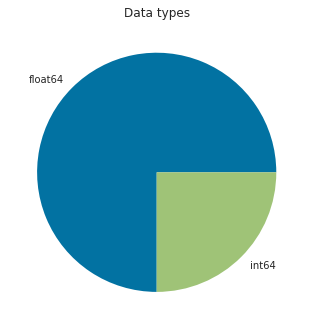

In [31]:
plot_dataframe_structure(df)

### Dataframe statistics

In [32]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
group,1177.0,1.299065,0.458043,1.000000,1.000000,1.000000,2.000000,2.000000
outcome,1176.0,0.135204,0.342087,0.000000,0.000000,0.000000,0.000000,1.000000
age,1177.0,74.055225,13.434061,19.000000,65.000000,77.000000,85.000000,99.000000
gendera,1177.0,1.525064,0.499584,1.000000,1.000000,2.000000,2.000000,2.000000
BMI,962.0,30.188278,9.325997,13.346801,24.326461,28.312474,33.633509,104.970366
hypertensive,1177.0,0.717927,0.450200,0.000000,0.000000,1.000000,1.000000,1.000000
atrialfibrillation,1177.0,0.451147,0.497819,0.000000,0.000000,0.000000,1.000000,1.000000
diabetes,1177.0,0.421410,0.493995,0.000000,0.000000,0.000000,1.000000,1.000000
deficiencyanemias,1177.0,0.338997,0.473570,0.000000,0.000000,0.000000,1.000000,1.000000
depression,1177.0,0.118946,0.323863,0.000000,0.000000,0.000000,0.000000,1.000000


### Which columns could be categorical ?

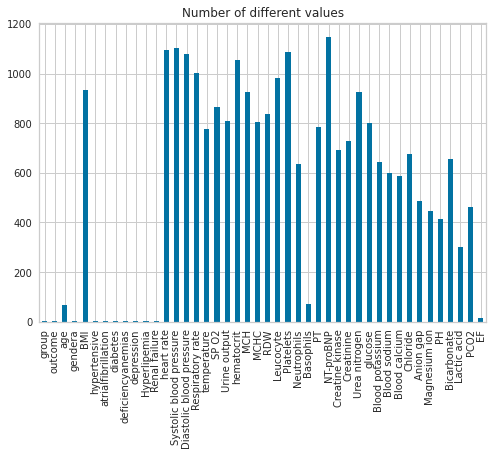

In [33]:
plot_categorical(df)

# Dataset Cleaning

### Duplicate rows:

In [34]:
duplicates(df)

No duplicate rows.


,group,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,0.0,72,1,37.588179,0,0,1,1,0,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,0.0,75,2,NaN,0,0,0,1,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,0.0,83,2,26.572634,0,0,0,1,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,0.0,43,2,83.264629,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,0.0,75,2,31.824842,1,0,0,1,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,2,0.0,62,1,25.516870,1,1,1,0,1,...,136.714286,10.271429,94.428571,20.142857,2.714286,NaN,27.714286,NaN,NaN,40
1173,2,0.0,78,1,25.822710,0,1,1,0,1,...,135.680000,10.523529,101.720000,18.160000,2.012500,NaN,20.480000,NaN,NaN,30
1174,2,0.0,85,2,23.891779,1,1,1,1,0,...,136.000000,8.466667,97.285714,14.000000,2.028571,NaN,28.857143,NaN,NaN,55
1175,2,0.0,79,2,35.288554,0,0,1,1,1,...,140.000000,8.183333,104.000000,15.750000,2.090000,NaN,24.375000,NaN,NaN,25


### Drop NaN:

In [35]:
df, drop_cols = drop_na(df, threshold_NaN)

Drop columns containing more than 50.0 % of NaN: []


Set of dropped columns: NaN

In [36]:
dropped_cols = np.unique(np.concatenate((drop_cols, user_drop_cols)))

In [37]:
display(dropped_cols)

array(['CHD with no MI', 'COPD', 'ID', 'INR', 'Lymphocyte', 'MCV', 'RBC'],
      dtype=object)

### Encoding data:

In [38]:
df, encoded_cols = encoding(df, threshold_cat, target_col)

Column  group  is categorical.
Column  outcome  is categorical.
Encoding numeric column: age
Column  gendera  is categorical.
Encoding numeric column: BMI
Column  hypertensive  is categorical.
Column  atrialfibrillation  is categorical.
Column  diabetes  is categorical.
Column  deficiencyanemias  is categorical.
Column  depression  is categorical.
Column  Hyperlipemia  is categorical.
Column  Renal failure  is categorical.
Encoding numeric column: heart rate
Encoding numeric column: Systolic blood pressure
Encoding numeric column: Diastolic blood pressure
Encoding numeric column: Respiratory rate
Encoding numeric column: temperature
Encoding numeric column: SP O2
Encoding numeric column: Urine output
Encoding numeric column: hematocrit
Encoding numeric column: MCH
Encoding numeric column: MCHC
Encoding numeric column: RDW
Encoding numeric column: Leucocyte
Encoding numeric column: Platelets
Encoding numeric column: Neutrophils
Encoding numeric column: Basophils
Encoding numeric column:

### Imputing NaN using IterativeImputer

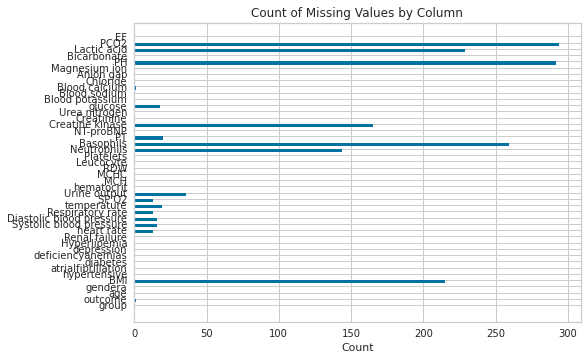

In [39]:
visualizer = MissingValuesBar(features=df.select_dtypes(include=np.number).columns.tolist())
visualizer.fit(df.select_dtypes(include=np.number))
visualizer.show();

#### Imputation

In [40]:
df = imputation(df)

Imputing NaN using IterativeImputer


### Data compression:

In [41]:
df = downcast_dtypes(df)

Memory usage of dataframe is 0.40MB
Memory usage after optimization is: 0.10MB
Decreased by 75.0%


#### Dataframe structure after compression

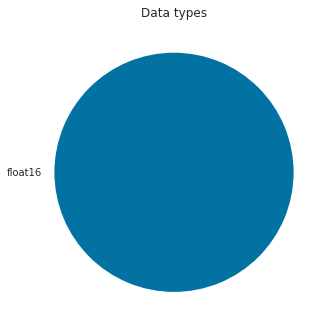

In [42]:
plot_dataframe_structure(df)

### Outliers:

In [43]:
df = outliers(df, threshold_Z)

Using Z_score,  298  rows will be suppressed.


# Plottings

# Ranking 

#### Ranking 1D 

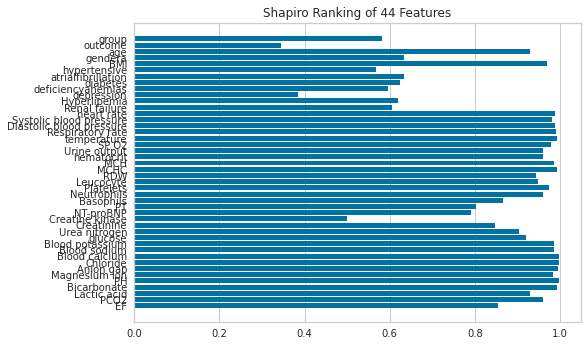

In [44]:
rank1d(df);

#### Ranking 2D 

##### Ranking 2D according to Pearson

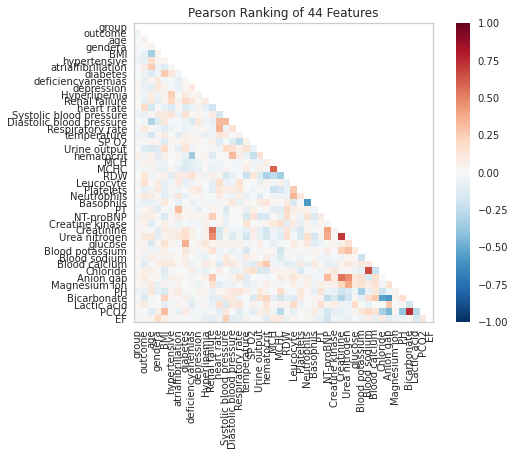

In [45]:
rank2d(df, algorithm='pearson');

##### Ranking 2D based on covariance

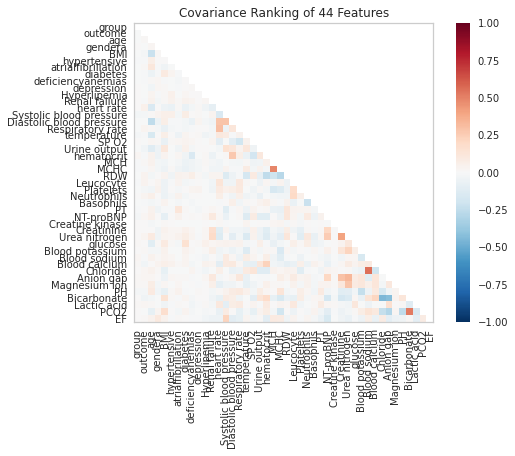

In [46]:
rank2d(df, algorithm='covariance');

##### Ranking 2D according to Spearman

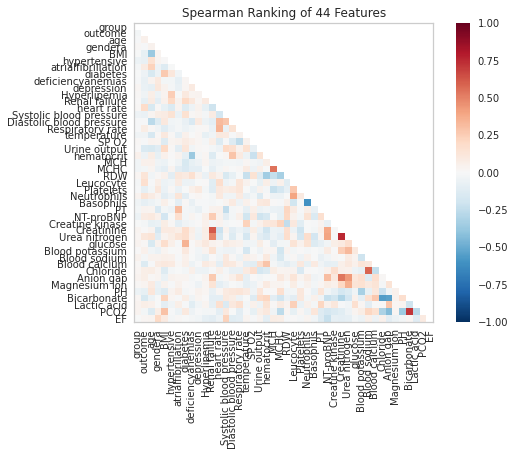

In [47]:
rank2d(df, algorithm='spearman');

##### Ranking 2D according to Kendalltau

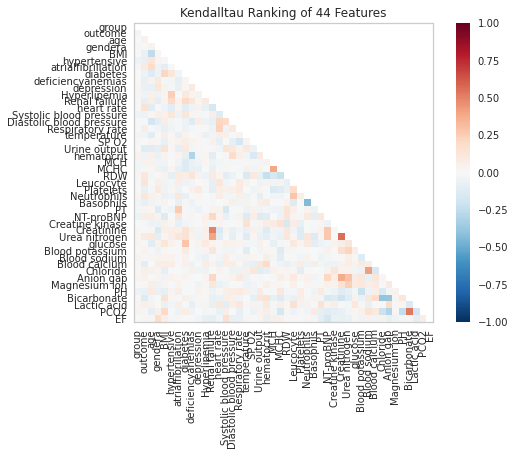

In [48]:
rank2d(df, algorithm='kendalltau');

# Correlation

In [49]:
corr = df.corr() 
corr.style.background_gradient(cmap='coolwarm')

,group,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,heart rate,Systolic blood pressure,Diastolic blood pressure,Respiratory rate,temperature,SP O2,Urine output,hematocrit,MCH,MCHC,RDW,Leucocyte,Platelets,Neutrophils,Basophils,PT,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
group,1.000000,-0.028128,-0.000057,0.008065,-0.021572,-0.061904,-0.022874,-0.005823,-0.011912,0.016956,0.009390,0.004289,0.007068,-0.057464,-0.007549,-0.017121,-0.043670,0.010134,-0.009496,0.050726,-0.027600,-0.026862,-0.006454,-0.022419,-0.002137,0.018733,-0.028644,-0.025055,-0.051472,0.013018,0.010502,0.011095,0.021916,0.005452,0.039206,0.020119,0.012460,0.032542,0.019728,-0.058573,0.002226,0.038546,0.021331,0.000191
outcome,-0.028128,1.000000,0.039336,-0.007295,-0.084738,-0.076909,0.081928,-0.053516,-0.071199,-0.069266,-0.036971,-0.092139,0.185313,-0.067990,-0.026842,0.087193,-0.054598,-0.008287,-0.126114,-0.052265,0.048944,-0.030859,0.124401,0.160533,-0.083697,0.124760,-0.079347,0.017044,0.075348,0.041274,0.011848,0.096545,0.029494,0.046680,-0.049426,-0.132869,0.060688,0.090682,0.037074,-0.085089,-0.146529,0.080016,-0.015410,0.030276
age,-0.000057,0.039336,1.000000,0.035464,-0.340679,0.168290,0.253026,-0.139225,0.026456,-0.114817,0.069666,0.100698,-0.177947,0.012778,-0.297914,0.011083,-0.187323,0.028602,-0.157656,0.049411,0.055443,0.025257,-0.035664,0.009467,-0.047875,0.080282,-0.064908,0.068082,0.074981,-0.113835,0.007305,0.117989,-0.141656,-0.026060,0.055717,0.005242,0.054799,0.022768,0.096682,0.117075,-0.031087,0.012986,-0.116096,0.046979
gendera,0.008065,-0.007295,0.035464,1.000000,0.036199,0.023562,-0.047938,-0.058422,0.097894,0.113173,-0.058814,-0.099849,0.010373,0.082351,-0.126063,-0.044743,0.013361,0.025577,-0.121298,-0.102210,-0.054106,-0.065515,0.007843,0.066156,0.108366,0.018259,-0.033403,-0.114122,0.007963,-0.009310,-0.127719,-0.104440,0.035587,-0.046464,0.024257,0.076885,0.021908,0.012893,-0.071117,-0.079030,-0.012500,-0.000037,0.060656,0.198837
BMI,-0.021572,-0.084738,-0.340679,0.036199,1.000000,0.021487,-0.128167,0.260972,-0.024422,0.041893,0.036272,0.042240,-0.073159,0.092401,0.106830,-0.117330,0.098382,-0.117774,0.191726,0.058483,-0.053598,-0.081685,0.061816,-0.086208,-0.090345,-0.109563,0.099624,-0.021183,-0.157093,0.063268,0.086978,0.042689,0.149504,0.073278,0.052787,0.094899,-0.124324,-0.089226,0.028385,-0.142209,0.227130,-0.093370,0.309539,0.067438
hypertensive,-0.061904,-0.076909,0.168290,0.023562,0.021487,1.000000,-0.003425,0.111824,-0.025276,-0.019059,0.242416,0.202883,-0.148333,0.131617,-0.028692,-0.048757,0.007201,0.038852,-0.006280,-0.006294,-0.007475,0.026525,-0.109028,-0.036090,0.014187,-0.046820,-0.015134,-0.036636,0.014398,0.011009,0.065247,0.058725,0.037395,-0.011556,0.048123,0.094570,-0.016857,0.056030,-0.008786,0.039063,0.027691,-0.026543,0.001364,-0.020141
atrialfibrillation,-0.022874,0.081928,0.253026,-0.047938,-0.128167,-0.003425,1.000000,-0.034550,-0.088229,-0.071631,-0.002001,0.042703,0.026268,-0.062158,-0.020640,-0.021151,-0.108899,0.039724,-0.096731,0.038909,-0.039354,-0.097494,0.094124,0.092054,-0.049770,0.112156,-0.082338,0.317556,0.104494,-0.049269,0.058228,0.105744,-0.041695,-0.006168,-0.006391,0.017919,-0.001541,0.031427,0.041134,0.098467,-0.019416,0.036407,-0.071118,0.022946
diabetes,-0.005823,-0.053516,-0.139225,-0.058422,0.260972,0.111824,-0.034550,1.000000,0.022200,0.020071,0.095414,0.197462,-0.134794,0.154993,-0.062418,-0.057267,0.052443,0.076195,0.133217,-0.086377,-0.137936,-0.149033,0.085558,-0.078449,0.001941,-0.080518,-0.000456,0.029879,0.018856,-0.008691,0.163001,0.182507,0.354517,0.110344,0.066220,0.066483,-0.014203,0.020498,-0.000908,-0.020330,0.066843,0.008696,0.085057,0.001647
deficiencyanemias,-0.011912,-0.071199,0.026456,0.097894,-0.024422,-0.025276,-0.088229,0.022200,1.000000,0.090779,0.029072,0

In [50]:
correlated_features = correlated_columns(df, threshold_corr, target_col) 
dropped_cols = np.unique(np.concatenate((drop_cols, correlated_features)))

#### Splitting dataframe in features and targets

In [51]:
y = df[target_col]

In [52]:
X = df.drop(target_col, axis=1)

##### Correlation with Yellow Bricks

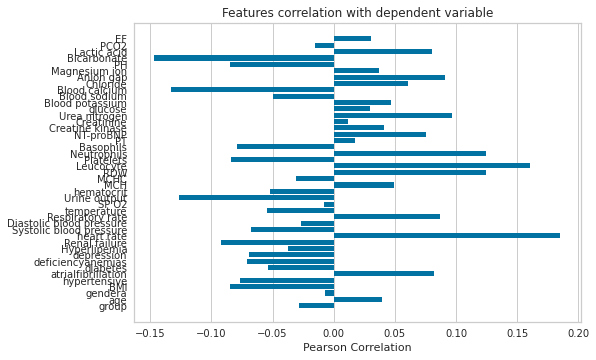

In [53]:
feature_correlation(X, y);

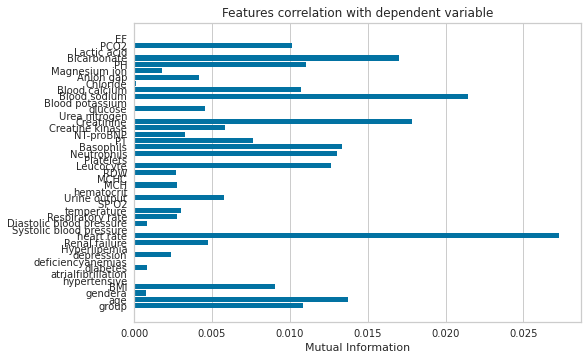

In [54]:
feature_correlation(X, y.astype(int), method='mutual_info-classification');

# Feature importance (a priori)

#### According to decision tree

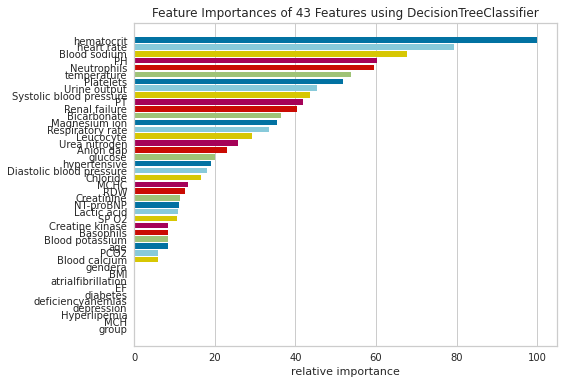

In [55]:
feature_importances(DecisionTreeClassifier(), X, y.astype(int));

#### According to logistic regression

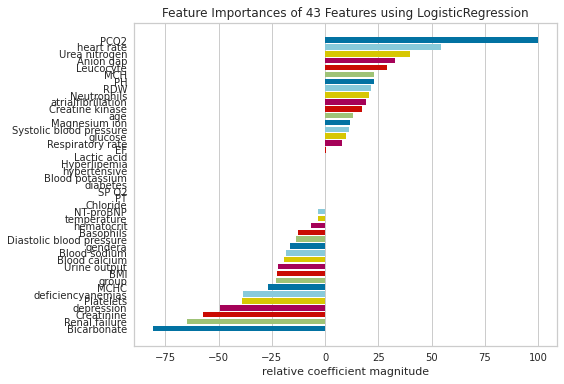

In [56]:
feature_importances(LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5), X, y.astype(int));

# PCA

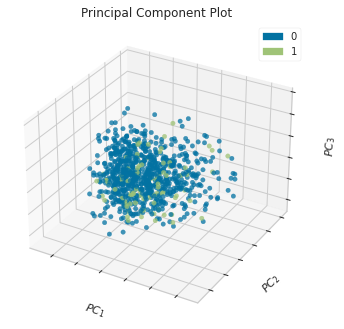

In [57]:
pca_decomposition(X, y.astype(int), projection=3);

# Class balancing

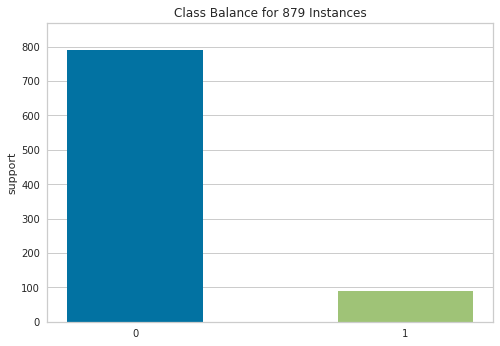

Entropy =  0.4729500020410867


In [58]:
class_balance(y.astype(int))
print('Entropy = ', shannon_entropy(y.astype(int)))

### Check columns that should be dropped

In [59]:
print(dropped_cols)

[]


# Splittings 

In [60]:
df = df_copy

## Resampling

In [61]:
cls_0=df[df[target_col]==0]
cls_1=df[df[target_col]==1]
df_class_1_over = cls_1.sample(250, replace=True)
df_class_0_over = cls_0.sample(250, replace=True)
df = pd.concat([df_class_0_over, df_class_1_over], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 547 to 446
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     500 non-null    int64  
 1   outcome                   500 non-null    float64
 2   age                       500 non-null    int64  
 3   gendera                   500 non-null    int64  
 4   BMI                       397 non-null    float64
 5   hypertensive              500 non-null    int64  
 6   atrialfibrillation        500 non-null    int64  
 7   diabetes                  500 non-null    int64  
 8   deficiencyanemias         500 non-null    int64  
 9   depression                500 non-null    int64  
 10  Hyperlipemia              500 non-null    int64  
 11  Renal failure             500 non-null    int64  
 12  heart rate                498 non-null    float64
 13  Systolic blood pressure   498 non-null    float64
 14  Diastoli

## Splitting dataframe in features and targets

In [62]:
y = df[target_col]

In [63]:
X = df.drop(target_col, axis=1)

## Dimensions

In [64]:
nb_features = len(X.columns.tolist())

In [65]:
nb_targets = len(y.unique())

In [66]:
layer_size = nb_features + nb_targets + 2

## Splitting data in train and test sets 

In [67]:
X_train, X_test, y_train, y_test = split(X, y, test_size=test_size, threshold_entropy=threshold_entropy, undersampling= undersampling, undersampler= undersampler, random_state = random_state)

## Encoding

In [68]:
target_encoder = LabelEncoder() 
y_train = pd.Series(target_encoder.fit_transform(y_train)) 
y_test = pd.Series(target_encoder.transform(y_test))

# Modelling

## Model building

### Pipeline building

#### Select the categorical and numerical columns

In [69]:
cat_selector = make_column_selector(dtype_include=object)

In [70]:
num_selector = make_column_selector(dtype_include=np.number)

#### For models based on tree

In [71]:
cat_tree_processor = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

In [72]:
num_tree_processor = make_pipeline(IterativeImputer(random_state=0, add_indicator=True))

In [73]:
tree_preprocessor = make_pipeline(make_column_transformer((num_tree_processor, num_selector), (cat_tree_processor, cat_selector)), Decorrelator(threshold_corr))

#### For models not based on tree

In [74]:
cat_ntree_processor = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore', sparse=False))

In [75]:
num_ntree_processor = make_pipeline(IterativeImputer(random_state=0, add_indicator=True), StandardScaler())

In [76]:
ntree_preprocessor = make_pipeline(make_column_transformer((num_ntree_processor, num_selector), (cat_ntree_processor, cat_selector)), Decorrelator(threshold_corr))

#### Keras neural network definition

In [77]:
def K_Class(): 
    keras.backend.clear_session() 
#   neural network architecture: start 
    model = Sequential() 
    model.add(BatchNormalization()) 
    model.add(Dense(layer_size, activation='selu')) 
#    model.add(LayerNormalization()) 
    model.add(BatchNormalization()) 
    model.add(Dropout(0.2)) 
    model.add(Dense(nb_targets, activation='softmax')) 
#   neural network architecture: end   
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


#### Early Stopping

In [78]:
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=20)

In [79]:
K_C = KerasClassifier(K_Class, batch_size=64, epochs=2000, callbacks=[es], validation_split=0.1, verbose=1) 
K_C._estimator_type = 'classifier'

#### Level-0 models

In [80]:
level_0 = [ 
          ('GPCL', make_pipeline(ntree_preprocessor, GaussianProcessClassifier(kernel = ConstantKernel() * DotProduct() + ConstantKernel() + WhiteKernel(), random_state = random_state))), 
          ('GPCR', make_pipeline(ntree_preprocessor, GaussianProcessClassifier(kernel = ConstantKernel() * RBF() + ConstantKernel() + WhiteKernel(), random_state = random_state))), 
          ('GPCQ', make_pipeline(ntree_preprocessor, GaussianProcessClassifier(kernel = ConstantKernel() * RationalQuadratic() + ConstantKernel() + WhiteKernel(), random_state = random_state))), 
          ('DTCG', make_pipeline(tree_preprocessor, DecisionTreeClassifier(criterion='gini', random_state = random_state))), 
          ('DTCE', make_pipeline(tree_preprocessor, DecisionTreeClassifier(criterion='entropy', random_state = random_state))), 
          ('RFCG', make_pipeline(tree_preprocessor, RandomForestClassifier(criterion='gini', n_estimators=100, random_state = random_state))), 
          ('RFCE', make_pipeline(tree_preprocessor, RandomForestClassifier(criterion='entropy', n_estimators=100, random_state = random_state))), 
          ('ABC', make_pipeline(tree_preprocessor, AdaBoostClassifier(random_state = random_state))), 
          ('HGBC', make_pipeline(tree_preprocessor, HistGradientBoostingClassifier(early_stopping=True, random_state = random_state))), 
          ('LOGRL', make_pipeline(ntree_preprocessor, LogisticRegression(solver='lbfgs', penalty='l2', random_state = random_state))), 
          ('LOGRS', make_pipeline(ntree_preprocessor, LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, random_state = random_state))), 
          ('LOGRLCV', make_pipeline(ntree_preprocessor, LogisticRegressionCV(cv=5, solver='lbfgs', penalty='l2', random_state = random_state))), 
          ('LOGRSCV', make_pipeline(ntree_preprocessor, LogisticRegressionCV(cv=5, solver='saga', penalty='l2', random_state = random_state))), 
          ('MLPC1', make_pipeline(ntree_preprocessor, MLPClassifier(hidden_layer_sizes = (layer_size, ), max_iter=2000, early_stopping=True, random_state = random_state))), 
          ('MLPC2', make_pipeline(ntree_preprocessor, MLPClassifier(hidden_layer_sizes = (layer_size, layer_size,), max_iter=2000, early_stopping=True, random_state = random_state))), 
          ('KNCU', make_pipeline(ntree_preprocessor, KNeighborsClassifier(weights='uniform', n_neighbors=len(y.unique())))), 
          ('KNCD', make_pipeline(ntree_preprocessor, KNeighborsClassifier(weights='distance', n_neighbors=len(y.unique())))), 
          ('GNB', make_pipeline(ntree_preprocessor, GaussianNB())), 
          ('KERC', make_pipeline(ntree_preprocessor, K_C)), 
          ]

#### Level-1 model

In [81]:
level_1 = DecisionTreeClassifier(random_state = random_state)

#### Stacking for classification

In [82]:
model = StackingClassifier(level_0, final_estimator=level_1)

# Model fitting

In [83]:
%%time 
set_config(display='diagram') 
model.fit(X_train, y_train)

2023-02-07 13:45:57.512915: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-07 13:45:57.665220: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2000
5/5 [==============================] - 2s 65ms/step - loss: 1.0906 - accuracy: 0.5415 - val_loss: 0.9327 - val_accuracy: 0.5882
Epoch 2/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.9814 - accuracy: 0.5648 - val_loss: 0.8353 - val_accuracy: 0.6176
Epoch 3/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.8515 - accuracy: 0.6080 - val_loss: 0.7548 - val_accuracy: 0.6471
Epoch 4/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.7381 - accuracy: 0.6711 - val_loss: 0.6967 - val_accuracy: 0.6471
Epoch 5/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.7395 - accuracy: 0.6279 - val_loss: 0.6546 - val_accuracy: 0.6471
Epoch 6/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.6498 - accuracy: 0.6678 - val_loss: 0.6200 - val_accuracy: 0.6471
Epoch 7/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.5763 - accuracy: 0.7010 - val_loss: 0.5976 - val_accuracy: 0.6765
Epoch 8/2000


StackingClassifier(estimators=[('GPCL',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('columntransformer',
                                                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                                                   Pipeline(steps=[('iterativeimputer',
                                                                                                                    IterativeImputer(add_indicator=True,
                                                                                                                                     random_state=0)),
                                                                                                                   ('standardscaler',
                                                                                                                    StandardScaler())]),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1df...
                                                                                                                   ('onehotencoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse=False))]),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1df123550>)])),
                                                                 ('decorrelator',
                                                                  Decorrelator(threshold=0.75))])),
                                                ('kerasclassifier',
                                                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd1df0a5890>)]))],
                   final_estimator=DecisionTreeClassifier(random_state=42))

# Model evaluation

### Model scoring

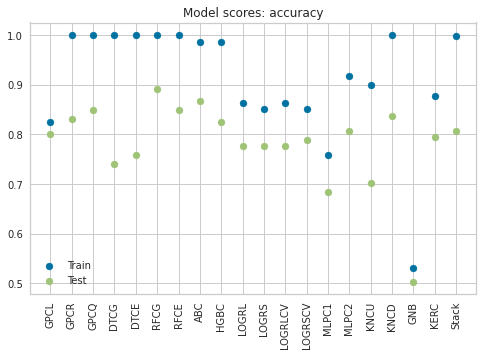

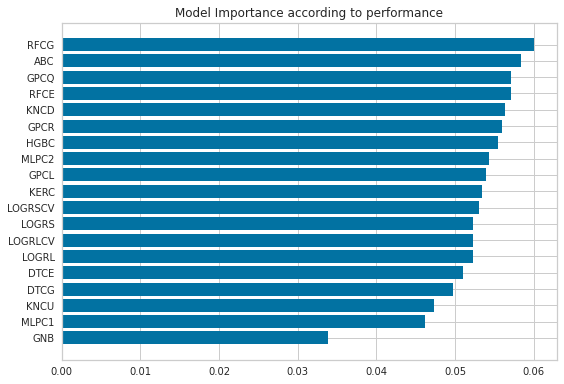

In [84]:
score_stack_0, mod_imp_score_0 = score_stacking(model, X_train, y_train, X_test, y_test)

### ROC/AUC

In [85]:
classes = y.unique()

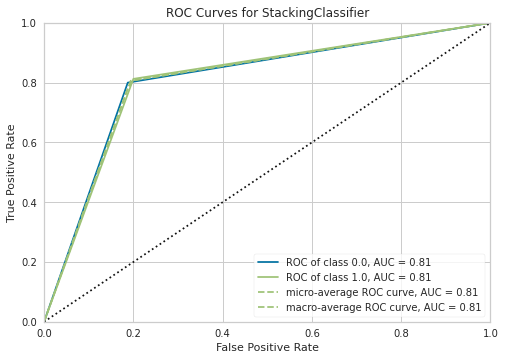

In [86]:
roc_auc(model, X_train, y_train, X_test = X_test, y_test = y_test, classes = classes);

### Classification report

In [87]:
K_classification_report(model, X_train, y_train, X_test, y_test)

,precision,recall,f1-score,support
0,0.993976,1.000000,0.996979,165.000000
1,1.000000,0.994118,0.997050,170.000000
accuracy,0.997015,0.997015,0.997015,0.997015
macro avg,0.996988,0.997059,0.997014,335.000000
weighted avg,0.997033,0.997015,0.997015,335.000000


,precision,recall,f1-score,support
0,0.819277,0.800000,0.809524,85.000000
1,0.792683,0.812500,0.802469,80.000000
accuracy,0.806061,0.806061,0.806061,0.806061
macro avg,0.805980,0.806250,0.805996,165.000000
weighted avg,0.806383,0.806061,0.806103,165.000000


### Confusion matrix

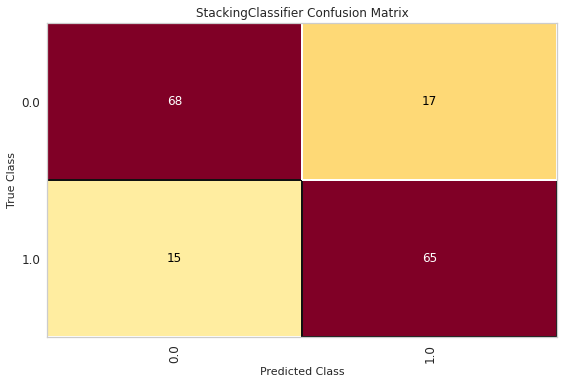

In [88]:
confusion_matrix(model, X_train, y_train, X_test, y_test, classes=classes);

### Class prediction error

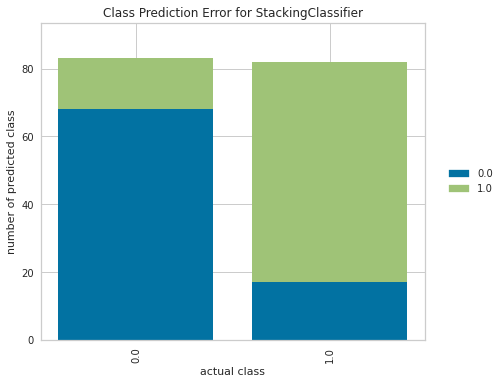

In [89]:
class_prediction_error(model, X_train, y_train, X_test, y_test, classes=classes);

# Model inspection

### Model importance

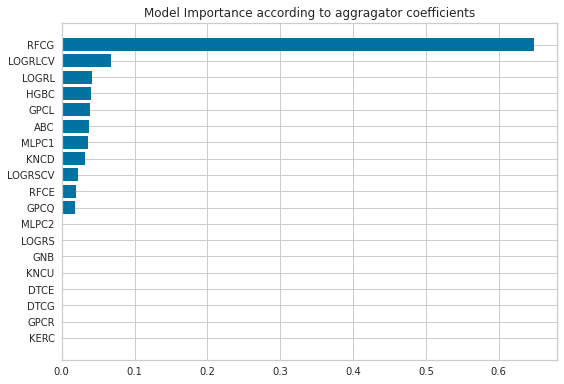

In [90]:
model_imp_0 = plot_model_importance(model, level_1_model)

### Feature permutation importance (a posteriori)

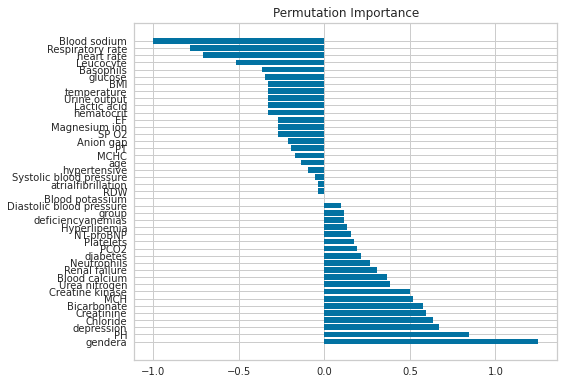

In [91]:
feature_importance_0 = plot_perm_importance(model, X_test, y_test, CPU)

# Level-0 model elimination

In [92]:
threshold_model = 5

In [93]:
threshold_score = 0.8

#### Filtered Level-0 models

In [94]:
level_0_f = model_filtering(level_0, model_imp_0, threshold_model, score_stack_0, threshold_score)

#### Level-1 model with filtration

In [95]:
level_1 = DecisionTreeClassifier(random_state = random_state)

#### Build filtered model

In [96]:
model = StackingClassifier(level_0_f, final_estimator=level_1)

# Filtered Model fitting

In [97]:
%%time 
set_config(display='diagram') 
model.fit(X_train, y_train)

CPU times: user 33.8 s, sys: 53.9 s, total: 1min 27s
Wall time: 24.4 s


StackingClassifier(estimators=[('RFCG',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('columntransformer',
                                                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                                                   Pipeline(steps=[('iterativeimputer',
                                                                                                                    IterativeImputer(add_indicator=True,
                                                                                                                                     random_state=0))]),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1df08f490>),
                                                                                                  ('pipeline-2',
                                                                                                   Pipeline(step...
                                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                                   ('onehotencoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse=False))]),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1df123550>)])),
                                                                 ('decorrelator',
                                                                  Decorrelator(threshold=0.75))])),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier(n_neighbors=2,
                                                                      weights='distance'))]))],
                   final_estimator=DecisionTreeClassifier(random_state=42))

# Filtered Model evaluation

### Filtered Model scoring

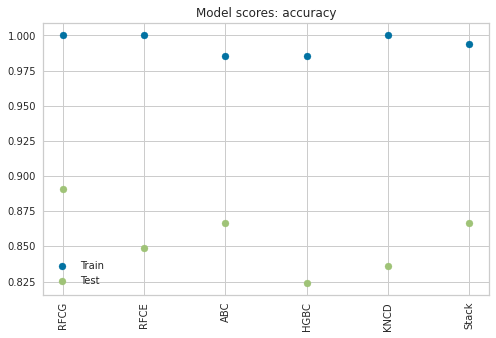

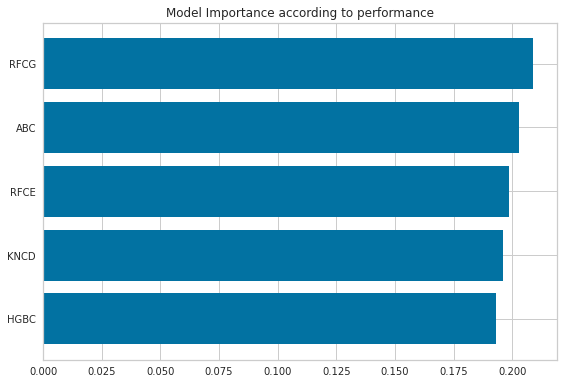

In [98]:
score_stack_1, mod_imp_score_1 = score_stacking(model, X_train, y_train, X_test, y_test)

### Filtered feature permutation importance

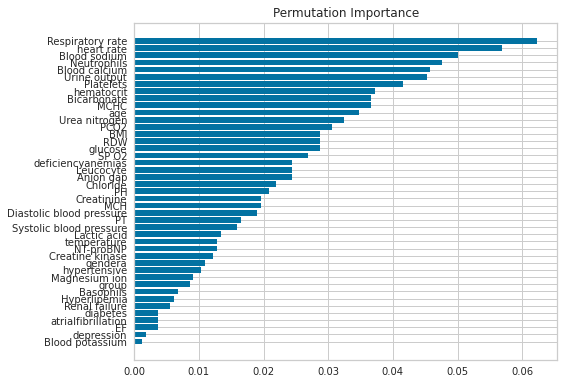

In [99]:
feature_importance_1 = plot_perm_importance(model, X_test, y_test, CPU)

#### Filtered feature elimination

In [100]:
best_feature, worst_feature = feature_filtering(feature_importance_1, threshold_feature)

In [101]:
dropped_cols = np.unique(np.concatenate((dropped_cols, worst_feature))).tolist()

### Check those columns, they should be dropped

In [102]:
print(dropped_cols)

['Anion gap', 'BMI', 'Basophils', 'Bicarbonate', 'Blood potassium', 'Chloride', 'Creatine kinase', 'Creatinine', 'Diastolic blood pressure', 'EF', 'Hyperlipemia', 'Lactic acid', 'Leucocyte', 'MCH', 'MCHC', 'Magnesium ion', 'NT-proBNP', 'PCO2', 'PH', 'PT', 'Platelets', 'RDW', 'Renal failure', 'SP O2', 'Systolic blood pressure', 'Urea nitrogen', 'Urine output', 'age', 'atrialfibrillation', 'deficiencyanemias', 'depression', 'diabetes', 'gendera', 'glucose', 'group', 'hematocrit', 'hypertensive', 'temperature']


### Filtered ROC/AUC

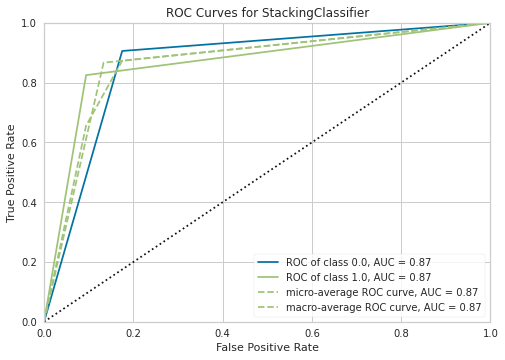

In [103]:
classes = y.unique() 
roc_auc(model, X_train, y_train, X_test = X_test, y_test = y_test, classes = classes);

### Filtered Confusion matrix

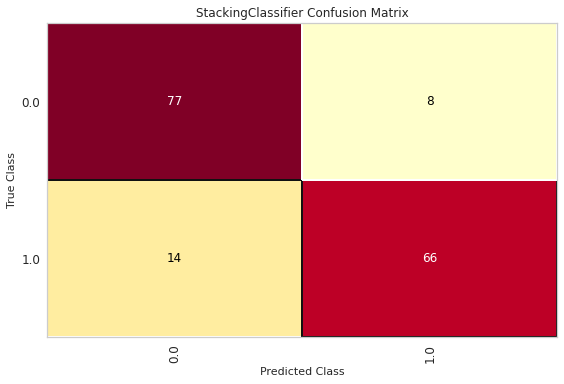

In [104]:
confusion_matrix(model, X_train, y_train, X_test, y_test, classes=classes);

### Filtered Class prediction error

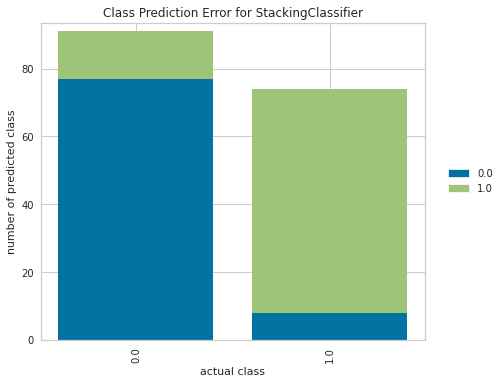

In [105]:
class_prediction_error(model, X_train, y_train, X_test, y_test, classes=classes);

# Filtered Model inspection

### Filtered Model importance

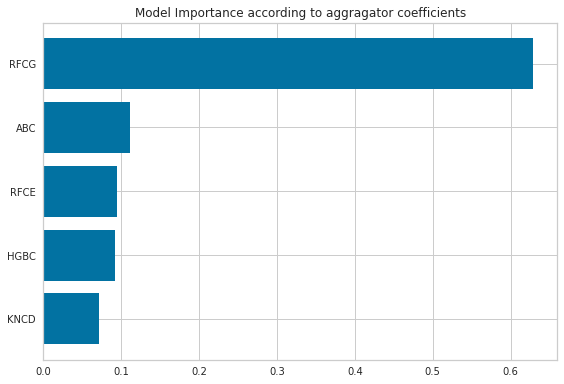

In [106]:
model_imp_1 = plot_model_importance(model, level_1_model)

### Filtered Feature permutation importance (a posteriori)

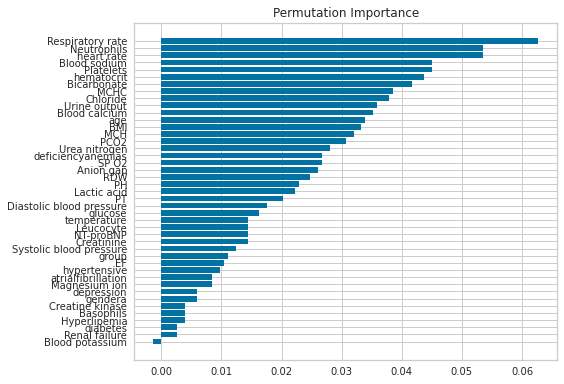

array([['Blood potassium', -0.0013054830287205733],
       ['Renal failure', 0.002610966057441266],
       ['diabetes', 0.002610966057441278],
       ['Hyperlipemia', 0.0039164490861618995],
       ['Basophils', 0.003916449086161912],
       ['Creatine kinase', 0.003916449086161923],
       ['gendera', 0.005874673629242848],
       ['depression', 0.005874673629242848],
       ['Magnesium ion', 0.008485639686684079],
       ['atrialfibrillation', 0.008485639686684103],
       ['hypertensive', 0.009791122715404737],
       ['EF', 0.01044386422976504],
       ['group', 0.01109660574412537],
       ['Systolic blood pressure', 0.012402088772845965],
       ['Creatinine', 0.014360313315926892],
       ['NT-proBNP', 0.014360313315926904],
       ['Leucocyte', 0.014360313315926914],
       ['temperature', 0.014360313315926928],
       ['glucose', 0.016318537859007852],
       ['Diastolic blood pressure', 0.017624020887728464],
       ['PT', 0.02023498694516974],
       ['Lactic acid', 0.022193

In [107]:
plot_perm_importance(model, X_test, y_test, CPU)

# Final Model

In [108]:
df = df.drop(dropped_cols, axis=1)

## Splitting dataframe in features and targets for final model

In [109]:
y = df[target_col] 

In [110]:
X = df.drop(target_col, axis=1) 

## Dimensions

In [111]:
nb_features = len(X.columns.tolist()) 

In [112]:
nb_targets = len(y.unique()) 

In [113]:
layer_size = nb_features + nb_targets + 2 

## Splitting data in train and test sets 

In [114]:
X_train, X_test, y_train, y_test = split(X, y, test_size=test_size, threshold_entropy=threshold_entropy, undersampling=undersampling, undersampler=undersampler, random_state=random_state) 

## Encoding

In [115]:
target_encoder = LabelEncoder() 
y_train = pd.Series(target_encoder.fit_transform(y_train)) 
y_test = pd.Series(target_encoder.transform(y_test)) 

#### Build final model

In [116]:
model = StackingClassifier(level_0_f, final_estimator=level_1)

# Final Model fitting

In [117]:
%%time 
set_config(display='diagram') 
model.fit(X_train, y_train)

CPU times: user 4.64 s, sys: 46 ms, total: 4.69 s
Wall time: 3.41 s


StackingClassifier(estimators=[('RFCG',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('columntransformer',
                                                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                                                   Pipeline(steps=[('iterativeimputer',
                                                                                                                    IterativeImputer(add_indicator=True,
                                                                                                                                     random_state=0))]),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1df08f490>),
                                                                                                  ('pipeline-2',
                                                                                                   Pipeline(step...
                                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                                   ('onehotencoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse=False))]),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1df123550>)])),
                                                                 ('decorrelator',
                                                                  Decorrelator(threshold=0.75))])),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier(n_neighbors=2,
                                                                      weights='distance'))]))],
                   final_estimator=DecisionTreeClassifier(random_state=42))

# Final Model evaluation

### Final Model scoring

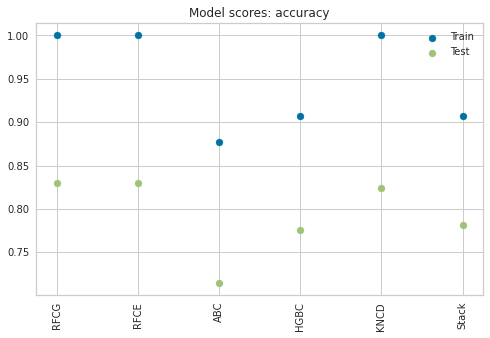

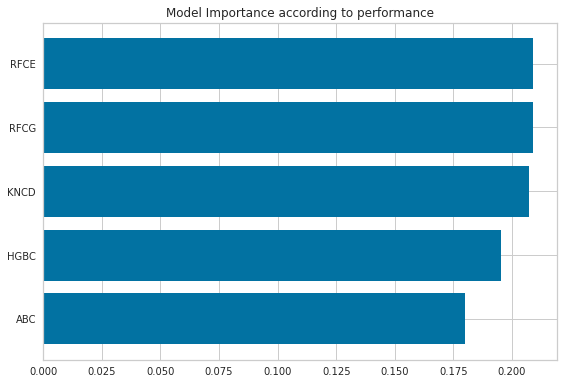

In [118]:
score_stack_2, mod_imp_score_2 = score_stacking(model, X_train, y_train, X_test, y_test)

### Final feature permutation importance

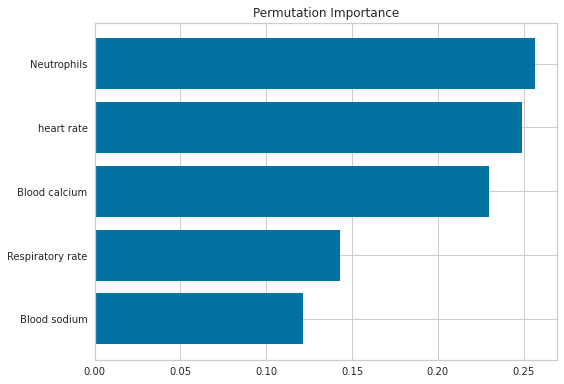

In [119]:
feature_importance_2 = feature_importance = plot_perm_importance(model, X_test, y_test, CPU)

### Final ROC/AUC

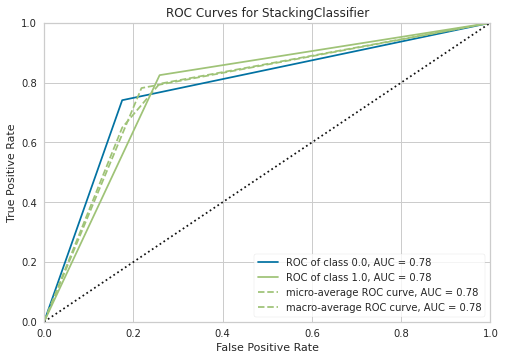

In [120]:
classes = y.unique() 
roc_auc(model, X_train, y_train, X_test = X_test, y_test = y_test, classes = classes);

### Final Classification report

In [121]:
K_classification_report(model, X_train, y_train, X_test, y_test)

,precision,recall,f1-score,support
0,0.958904,0.848485,0.900322,165.000000
1,0.867725,0.964706,0.913649,170.000000
accuracy,0.907463,0.907463,0.907463,0.907463
macro avg,0.913314,0.906595,0.906985,335.000000
weighted avg,0.912634,0.907463,0.907085,335.000000


,precision,recall,f1-score,support
0,0.818182,0.741176,0.777778,85.000000
1,0.750000,0.825000,0.785714,80.000000
accuracy,0.781818,0.781818,0.781818,0.781818
macro avg,0.784091,0.783088,0.781746,165.000000
weighted avg,0.785124,0.781818,0.781626,165.000000


### Final Confusion matrix

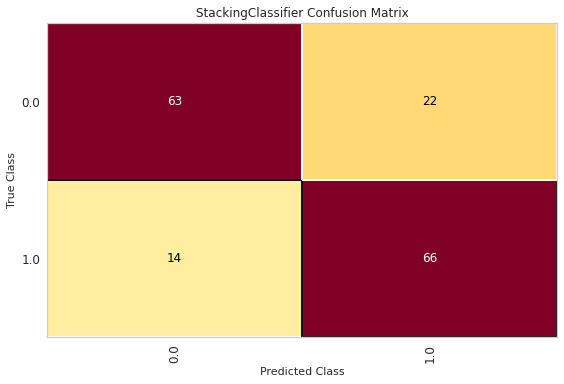

In [122]:
confusion_matrix(model, X_train, y_train, X_test, y_test, classes=classes);

### Final Class prediction error

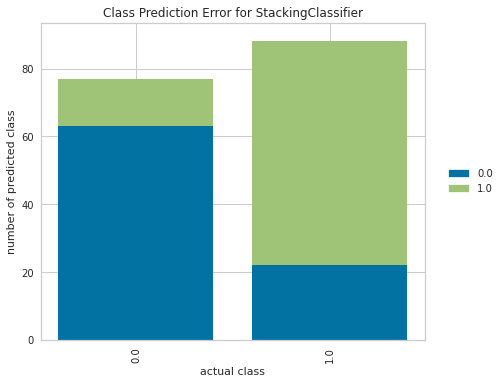

In [123]:
class_prediction_error(model, X_train, y_train, X_test, y_test, classes=classes);

# Final Model inspection

### Final Model importance

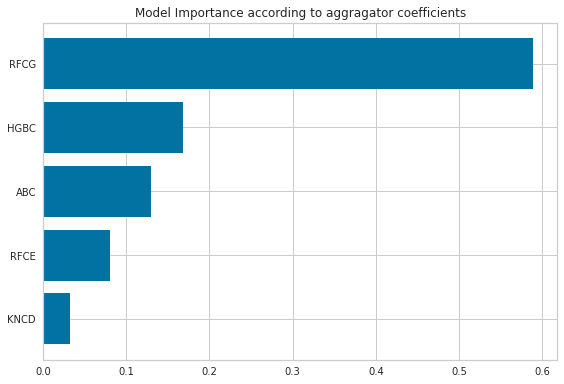

In [124]:
model_imp_2 = plot_model_importance(model, level_1_model)

### Final Feature permutation importance (a posteriori)

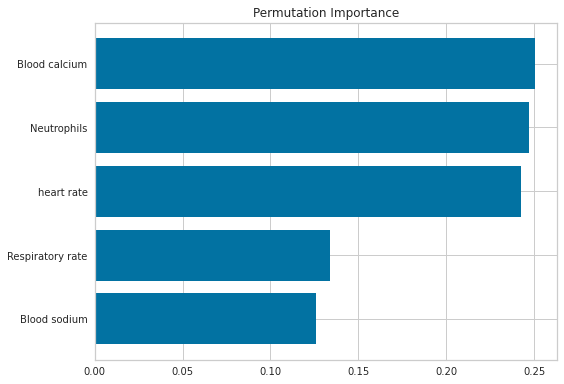

array([['Blood sodium', 0.12585812356979406],
       ['Respiratory rate', 0.13386727688787187],
       ['heart rate', 0.24256292906178487],
       ['Neutrophils', 0.24713958810068642],
       ['Blood calcium', 0.2505720823798627]], dtype=object)

In [125]:
plot_perm_importance(model, X_test, y_test, CPU)

### Final Partial Dependence & Individual Conditional Expectation 

#### Final Features of interest

In [126]:
features_of_interest = []

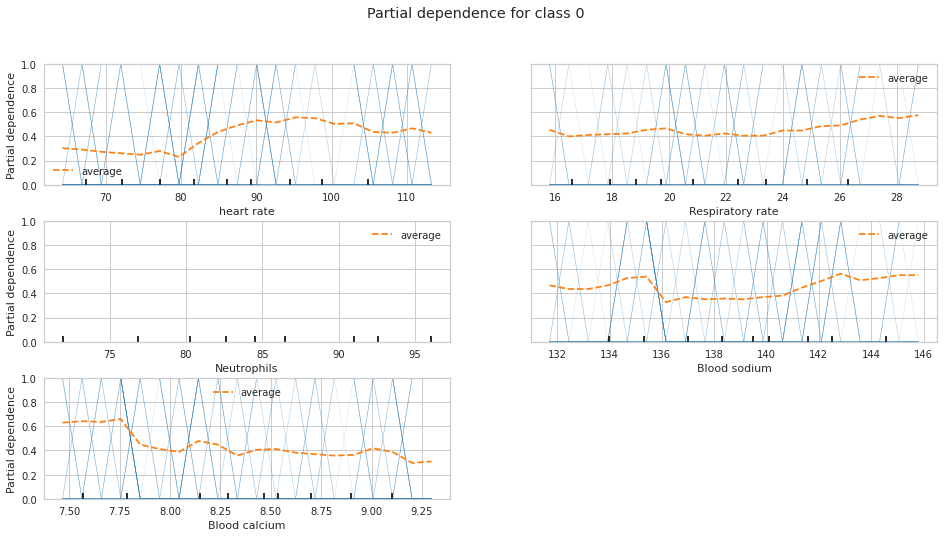

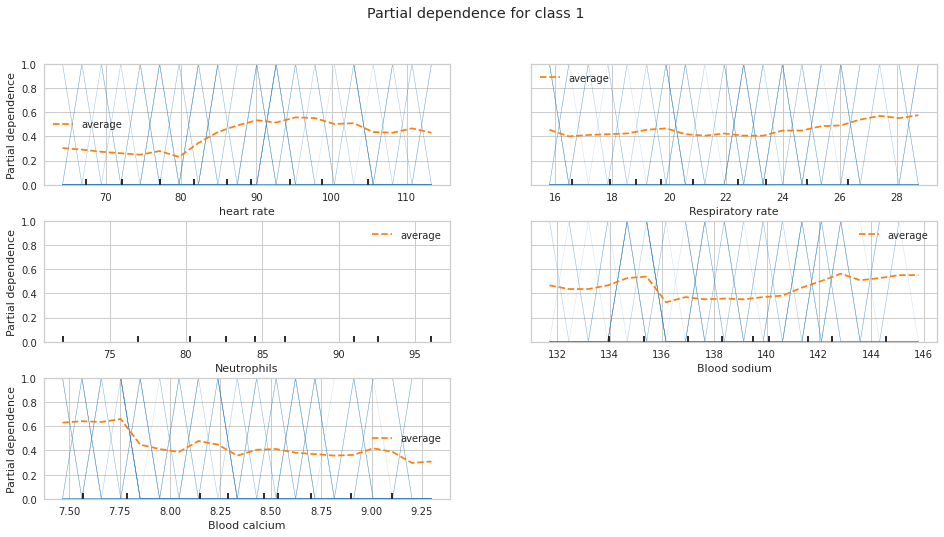

In [127]:
plot_partial_dependence(model, X_test, features_of_interest, CPU)  

In [128]:
#store_data(name, level_1_model, score_stack_0, score_stack_1, score_stack_2, 
#           model_imp_0, model_imp_1, model_imp_2, 
#           feature_importance_0, feature_importance_1, feature_importance_2)